<a href="https://colab.research.google.com/github/astrodeepnet/vae_mpoe/blob/main/VAE_HSC_bands.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


SB_10_v11_BASTI_baseFe_KU.fits	SB_2_v11_BASTI_baseFe_KU.fits  SB_6_v11_BASTI_baseFe_KU.fits
SB_11_v11_BASTI_baseFe_KU.fits	SB_3_v11_BASTI_baseFe_KU.fits  SB_7_v11_BASTI_baseFe_KU.fits
SB_12_v11_BASTI_baseFe_KU.fits	SB_4_v11_BASTI_baseFe_KU.fits  SB_8_v11_BASTI_baseFe_KU.fits
SB_1_v11_BASTI_baseFe_KU.fits	SB_5_v11_BASTI_baseFe_KU.fits  SB_9_v11_BASTI_baseFe_KU.fits
[   30.    40.    50.    60.    70.    80.    90.   100.   150.   200.
   250.   300.   350.   400.   450.   500.   600.   700.   800.   900.
  1000.  1250.  1500.  1750.  2000.  2250.  2500.  2750.  3000.  3250.
  3500.  3750.  4000.  4500.  5000.  5500.  6000.  6500.  7000.  7500.
  8000.  8500.  9000.  9500. 10000. 10500. 11000. 11500. 12000. 12500.
 13000. 13500. 14000.]


<ipython-input-3-e6369c51cfd3>:12: RuntimeWarning: divide by zero encountered in log10
  plt.pcolor(np.log10(hdulist[0].data))


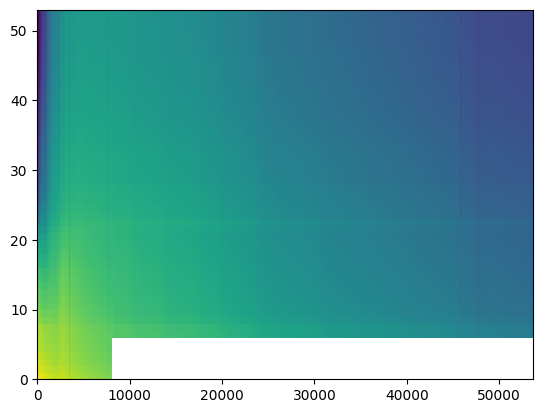

In [3]:
!ls '/content/drive/My Drive/EMILES'

from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np

hdulist = fits.open('/content/drive/My Drive/EMILES/SB_9_v11_BASTI_baseFe_KU.fits')
np.log10(hdulist['ETS_PARA'].data['ZSTARS'] / 0.02)

print(hdulist['ETS_PARA'].data['AGE'])

plt.pcolor(np.log10(hdulist[0].data))
plt.show()



In [4]:
import requests

def fetch_filter_data(filters):
    filter_dict = {}

    for name, url in filters:
        response = requests.get(url)
        if response.status_code == 200:
            data = response.text.splitlines()
            wavelength, transmission = [], []

            for line in data:
                parts = line.split()
                if len(parts) == 2:
                    try:
                        wavelength.append(float(parts[0]))
                        transmission.append(float(parts[1]))
                    except ValueError:
                        continue  # Skip lines that cannot be converted

            filter_dict[name] = {
                "wl": wavelength,
                "tr": transmission
            }
        else:
            print(f"Failed to fetch data for {name}")

    return filter_dict

filters = [['HSCg', 'http://svo2.cab.inta-csic.es/svo/theory/fps/getdata.php?format=ascii&id=Subaru/HSC.g_filter'],
           ['HSCr', 'http://svo2.cab.inta-csic.es/svo/theory/fps/getdata.php?format=ascii&id=Subaru/HSC.r_filter'],
           ['HSCi', 'http://svo2.cab.inta-csic.es/svo/theory/fps/getdata.php?format=ascii&id=Subaru/HSC.i_filter'],
           ['HSCz', 'http://svo2.cab.inta-csic.es/svo/theory/fps/getdata.php?format=ascii&id=Subaru/HSC.z_filter'],
           ['HSCY', 'http://svo2.cab.inta-csic.es/svo/theory/fps/getdata.php?format=ascii&id=Subaru/HSC.Y_filter']]
filer_names = [name for name, _ in filters]

filter_data = fetch_filter_data(filters)


In [5]:
import os
import os
import glob
import numpy as np
from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt
import requests
from scipy.interpolate import interp1d

spec_points = 100
spec_range = (3900, 10200)

def bin_spectrum(spec, wl, spec_range, spec_points):
    min_wl, max_wl = spec_range
    bins = np.linspace(min_wl, max_wl, spec_points + 1)
    mean_values = []
    wl_values = []

    for i in range(len(bins) - 1):
        bin_mask = (wl >= bins[i]) & (wl < bins[i+1])
        bin_data = spec[bin_mask]
        mean_values.append(bin_data.mean() if bin_data.size > 0 else (bins[i] + bins[i+1]) / 2)
        wl_values.append(0.5*(bins[i] + bins[i+1]))
    return np.array(mean_values), np.array(wl_values)


def get_waves(hdr):
     waves = hdr['CRVAL1'] - (hdr['CRPIX1']-1.0)*hdr['CDELT1'] + ( np.arange(0., hdr['NAXIS1']) ) * hdr['CDELT1']
     ran = [waves[0], waves[-1]]
     return waves



def read_fits_files(directory):
    # Define the file pattern to match
    file_pattern = os.path.join(directory, "SB_?_v11_BASTI_baseFe_KU.fits")
    fits_files = glob.glob(file_pattern)

    all_spectra = []
    all_params = []

    for fits_file in fits_files:
        with fits.open(fits_file) as hdul:
            spectra = hdul[0].data  # Extracting spectral data
            params = hdul[1].data  # Extracting table data
            wl = get_waves(hdul[0].header)
            all_spectra.extend(spectra*wl**2)
            all_params.append(np.array([tuple(row) for row in params]))  # Ensure structured array consistency

    # Stack spectra along a new axis if necessary (e.g., assuming same dimensions)
    stacked_spectra = np.array(all_spectra)  # Convert list to numpy array

    # Convert list of structured arrays into a single structured array
    structured_params = np.concatenate(all_params) if all_params else None

    # Create an Astropy Table
    result_table = Table(rows=structured_params, names=params.names)

    wl = get_waves(hdul[0].header)
    return stacked_spectra, result_table, wl

# Example usage
directory = "/content/drive/My Drive/EMILES/"  # Change to the directory containing your FITS files
spectra, param_table, wl = read_fits_files(directory)


 AGE   AGEBOL MGAL MSTARS MWD MBHNS MSUB    ZSTARS       ZBOL   
------ ------ ---- ------ --- ----- ---- ----------- -----------
1000.0 1000.0  1.0    1.0 0.0   0.0  0.0 0.022963073 0.022963073


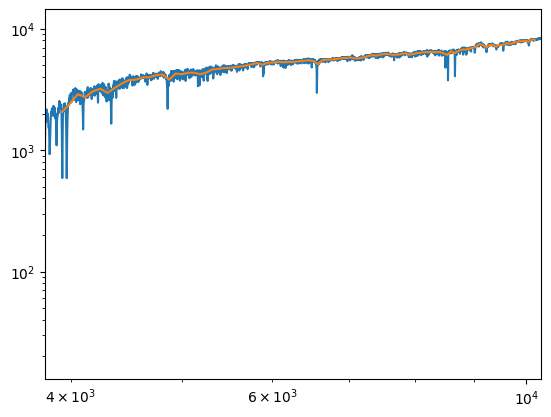

In [6]:
age = 1000
met = 0.02
da = np.abs(param_table['AGE'] - age)
dm = np.abs(param_table['ZSTARS'] - met)
idx = np.where((da == np.min(da)) & (dm == np.min(dm)))[0]
print(param_table[idx])
spec = spectra[idx][0]

speclr, wllr = bin_spectrum(spec, wl, spec_range, spec_points)

plt.plot(wl, spec)
plt.plot(wllr, speclr)
plt.xlim(3800, 10300)
plt.xscale('log')
plt.yscale('log')


def calc_spec(spectra, param_table, wl, age = 1000, met = 0.02, z=0.0):
    da = np.abs(param_table['AGE'] - age)
    dm = np.abs(param_table['ZSTARS']/met - 1)
    idx = np.where((da == np.min(da)) & (dm == np.min(dm)))[0]
    spec = spectra[idx][0]
    return (spec, wl*(1 + z))

In [7]:
def download_filter_curve(url):
    """Download and parse the filter transmission curve from a given URL."""
    response = requests.get(url)
    response.raise_for_status()
    data = np.loadtxt(response.iter_lines())
    return data[:, 0], data[:, 1]  # wavelengths, transmissions

def calculate_flux_and_mag(spectra_list, wavelengths_list, filters):
    """Calculate the flux and AB magnitude for multiple spectra and filters."""
    all_results = []
    all_speclr = []
    all_wllr = []

    for spectra, wavelengths in zip(spectra_list, wavelengths_list):
        results = []
        speclr, wllr = bin_spectrum(spectra, wavelengths, spec_range, spec_points)
        for filter_name, filter_url in filters:
            #filter_wavelengths, transmissions = download_filter_curve(filter_url)
            fd = filter_data[filter_name]
            filter_wavelengths, transmissions = fd['wl'], fd['tr']
            # Interpolate spectra onto the filter transmission wavelengths
            interp_flux = interp1d(wavelengths, spectra, kind='linear', fill_value=0, bounds_error=False)
            flux_interp = interp_flux(filter_wavelengths)
            filter_wavelengths = np.array(filter_wavelengths)
            # Calculate total flux (assuming simple integration)
            total_flux = np.trapz(flux_interp * transmissions, filter_wavelengths)
            total_flux /= np.trapz(transmissions, filter_wavelengths)
            #total_flux /= np.nanmax(total_flux)

            # Calculate AB magnitude
            if total_flux > 0:
                ab_magnitude = -2.5 * np.log10(total_flux) - 48.6  # AB mag formula
            else:
                ab_magnitude = np.inf  # Undefined magnitude for zero flux

            results.append([filter_name, total_flux, ab_magnitude])

        all_results.append(results)
        all_speclr.append(speclr)
        all_wllr.append(wllr)

    return all_results, [all_speclr, all_wllr]


filters = [['HSCg', 'http://svo2.cab.inta-csic.es/svo/theory/fps/getdata.php?format=ascii&id=Subaru/HSC.g_filter'],
           ['HSCr', 'http://svo2.cab.inta-csic.es/svo/theory/fps/getdata.php?format=ascii&id=Subaru/HSC.r_filter'],
           ['HSCi', 'http://svo2.cab.inta-csic.es/svo/theory/fps/getdata.php?format=ascii&id=Subaru/HSC.i_filter'],
           ['HSCz', 'http://svo2.cab.inta-csic.es/svo/theory/fps/getdata.php?format=ascii&id=Subaru/HSC.z_filter'],
           ['HSCY', 'http://svo2.cab.inta-csic.es/svo/theory/fps/getdata.php?format=ascii&id=Subaru/HSC.Y_filter']]

spectra_list = []
wavelengths_list = []

z_vals = np.arange(0, 1.3, 0.05)
age_vals = np.arange(1000, 13000, 500, dtype=np.float64)
age_vals = np.concatenate((age_vals, np.array([400, 600, 800])))
#age_vals = np.concatenate((age_vals, np.arange(1000, 4000, 250, dtype=np.float64)))
age_vals.sort()
print(age_vals)

metdex_vals = [0.15, 0, -0.25, -0.35] #, -0.66,-0.96]
param_list = []

for i,z in enumerate(z_vals):
    for j,age in enumerate(age_vals):
        for k,metdex in enumerate(metdex_vals):
            gen = calc_spec(spectra, param_table, wl, age = age, met = 0.02*10**metdex, z=z)
            spectra_list.append(gen[0])
            wavelengths_list.append(gen[1])
            param_list.append([z, age, metdex])  # Store the corresponding parameters


print(len(spectra_list))
print(len(wavelengths_list))
mags, lr = calculate_flux_and_mag(spectra_list, wavelengths_list, filters)

output_array = [[[entry[1] for entry in mag_entry], params, speclr] for mag_entry, params, speclr in zip(mags, param_list, lr[0])]

[  400.   600.   800.  1000.  1500.  2000.  2500.  3000.  3500.  4000.
  4500.  5000.  5500.  6000.  6500.  7000.  7500.  8000.  8500.  9000.
  9500. 10000. 10500. 11000. 11500. 12000. 12500.]
2808
2808


<ipython-input-7-b0c5b9ff887b>:26: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  total_flux = np.trapz(flux_interp * transmissions, filter_wavelengths)
<ipython-input-7-b0c5b9ff887b>:27: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  total_flux /= np.trapz(transmissions, filter_wavelengths)


In [8]:

output_array = [[[float(val) for val in flux_list], [float(params[0]), float(params[1]), params[2]], lr] for flux_list, params, lr in output_array]

print(len(output_array))

N_smpl = 80  # Number of realizations per entry

# Create new array with perturbations
dataset_rnd = []

for flux_list, params, lr in output_array:
    for _ in range(N_smpl):
        perturbed_flux = [val + 0.1 * np.random.uniform(0, 1) * val for val in flux_list]  # Add perturbation
        dataset_rnd.append([perturbed_flux, params, lr])  # Duplicate params as required


integrals = np.array([entry[0] / np.max(entry[0]) for entry in dataset_rnd])  # 2D array of flux values
params = np.array([entry[1] for entry in dataset_rnd])  # 2D array of corresponding parameters
params[:, 1] /= 1e4
spectra = np.array([entry[2] / np.max(entry[2]) for entry in dataset_rnd])  # 2D array of corresponding parameters
#spectra = 1e5 * np.array(spectra)


2808


In [9]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import tensorflow as tf
import keras
from keras import ops
from keras import layers

import numpy as np
import matplotlib.pyplot as plt



class Sampling(layers.Layer):

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.seed_generator = keras.random.SeedGenerator(1337)

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = ops.shape(z_mean)[0]
        dim = ops.shape(z_mean)[1]
        epsilon = keras.random.normal(shape=(batch, dim), seed=self.seed_generator)
        return z_mean + ops.exp(0.5 * z_log_var) * epsilon


def build_dense_encoder_sed_branch(input_shape):
    dense_input = keras.Input(shape=input_shape)
#    x = layers.Dense(64, activation='relu')(dense_input)
#    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dense(32, activation='relu')(dense_input)
    x = layers.Dense(16, activation='relu')(x)
    return keras.Model(dense_input, x, name='dense_encoder_branch')

def build_dense_decoder_sed(latent_dim, output_dim):
    latent_inputs = keras.Input(shape=(latent_dim,), name=f'z_sampling')
    x = layers.Dense(16, activation='relu')(latent_inputs)
    x = layers.Dense(32, activation='relu')(x)
#    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(output_dim, activation='sigmoid')(x)
    return keras.Model(latent_inputs, outputs, name='dense_decoder')

def build_encoder_sp_branch(input_shape):
    cnn_input = keras.Input(shape=input_shape)
    #x = layers.Conv1D(32, 3, activation='relu', strides=2, padding='same')(cnn_input)
    #x = layers.Conv1D(64, 3, activation='relu', strides=2, padding='same')(x)
    #x = layers.Conv1D(128, 3, activation='relu', strides=2, padding='same')(x)
    x = layers.Flatten()(cnn_input)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(64, activation='relu')(x)
    return keras.Model(cnn_input, x, name='cnn_encoder')

def build_dense_decoder_sp(latent_dim, output_dim):
    latent_inputs = layers.Input(shape=(latent_dim,), name='z_sampling')
    x = layers.Dense(16, activation='relu')(latent_inputs)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dense(128, activation='relu')(x)
    #x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(128, activation='relu')(x)
    #x = layers.Dense(256, activation='relu')(x)
    #x = layers.Dense(256, activation='relu')(x)
    x = layers.Dense(256, activation='relu')(x)
    outputs = layers.Dense(output_dim[0])(x)
    #outputs = layers.Reshape(output_dim)(x)

    decoder = keras.Model(latent_inputs, outputs, name='dense_decoder')
    return decoder


def corner_plot(r, max_params):
    axs = tuple(range(min(max_params, r[0].shape[1])))  # Ensure indices do not exceed max dimensions
    fig, axes = plt.subplots(len(axs), len(axs), figsize=(10, 10))

    for i, ax_i in enumerate(axs):
        for j, ax_j in enumerate(axs):
            ax = axes[i, j]

            if i == j:
                # Diagonal: 1D histogram
                ax.hist(r[0][:, ax_i], bins=100, color='steelblue', alpha=0.7)
            elif i > j:
                # Lower triangle: 2D histogram
                ax.hist2d(r[0][:, ax_j], r[0][:, ax_i], bins=100, cmap='Blues')
            else:
                # Upper triangle: empty space
                ax.set_visible(False)

            # Remove ticks for clarity
            ax.set_xticks([])
            ax.set_yticks([])

    plt.tight_layout()

In [10]:
class SpectraVAE(keras.Model):
    def __init__(self, input_dim, latent_dim, beta=1, **kwargs):
        super().__init__(**kwargs)
        self.encoder_branch = build_encoder_sp_branch((input_dim,1))

        self.z_mean = layers.Dense(latent_dim, name='z_mean')(self.encoder_branch.output)
        self.z_log_var = layers.Dense(latent_dim, name='z_log_var')(self.encoder_branch.output)

        self.z = Sampling()([self.z_mean, self.z_log_var])

        self.encoder = keras.Model(self.encoder_branch.inputs, [self.z_mean, self.z_log_var, self.z], name='cnn_encoder')

        self.decoder = build_dense_decoder_sp(latent_dim,(input_dim,1))
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.beta = beta
        #super().__init__(inputs=self.encoder.input, outputs=self.decoder.output, **kwargs)

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def apply(self, data):
        z_mean, z_log_var, z = self.encoder(data)
        reconstruction = self.decoder(z)
        return (z_mean, z_log_var, z, reconstruction)

    def call(self, data):
        return self.apply(data)[3]



    def train_step(self, data):
        with tf.GradientTape() as tape:
            (z_mean, z_log_var, z, reconstruction) = self.apply(data)
            reconstruction_loss = ops.mean(
                tf.keras.backend.mean(tf.keras.backend.square((data - reconstruction)/data))
            )
            kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
            kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss*self.beta
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
       }

    def test_step(self, data):
        (z_mean, z_log_var, z, reconstruction) = self.apply(data)
        reconstruction_loss = ops.mean(
                tf.keras.backend.mean(tf.keras.backend.square((data - reconstruction)/data))
        )
        kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
        kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
        total_loss = reconstruction_loss + kl_loss*self.beta
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

[0.   0.1  0.15]


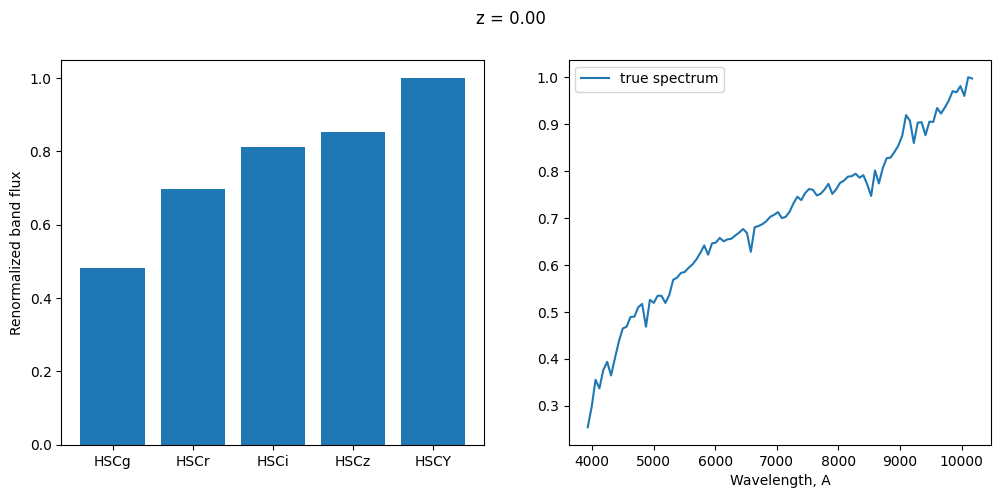

[0.   0.1  0.15]


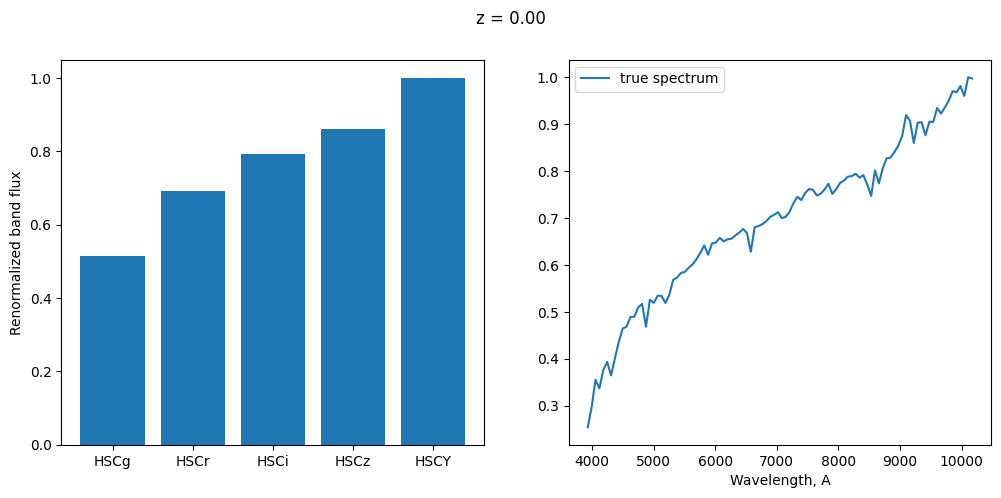

[0.   0.1  0.15]


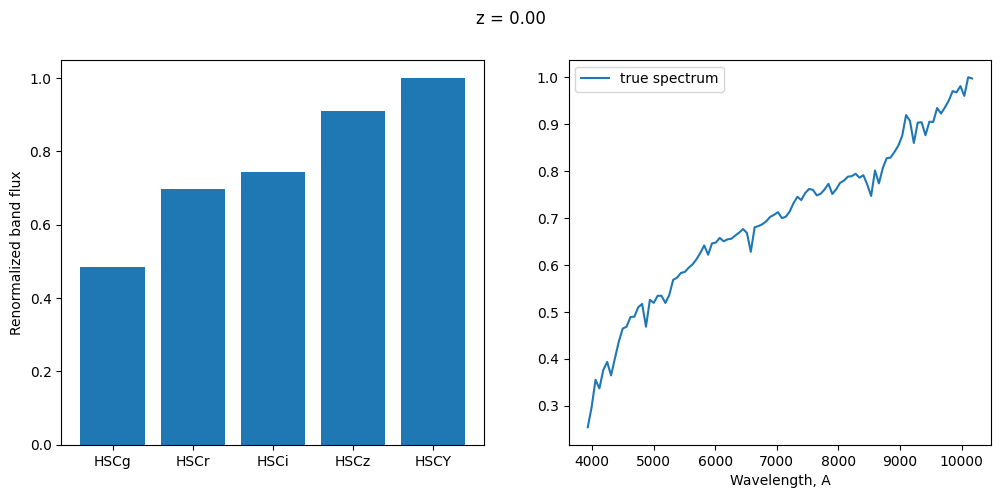

[0.   0.1  0.15]


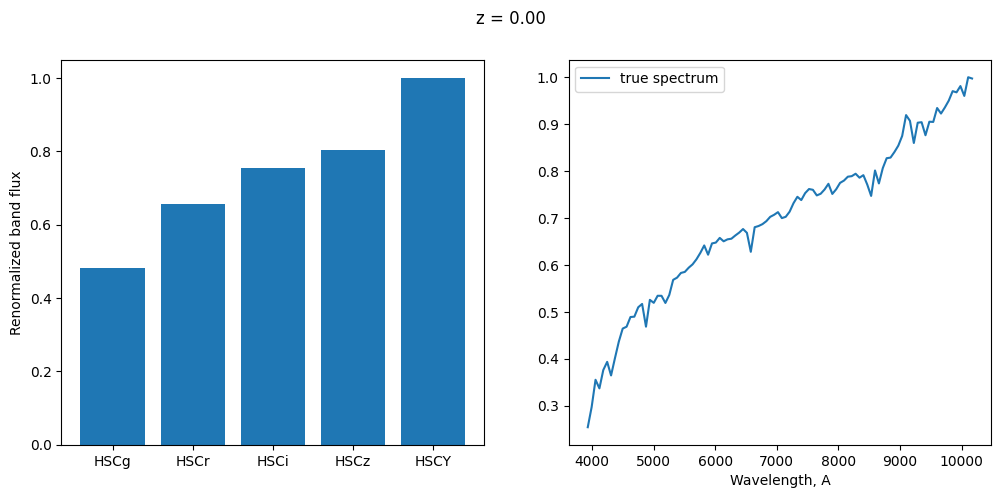

[0.   0.1  0.15]


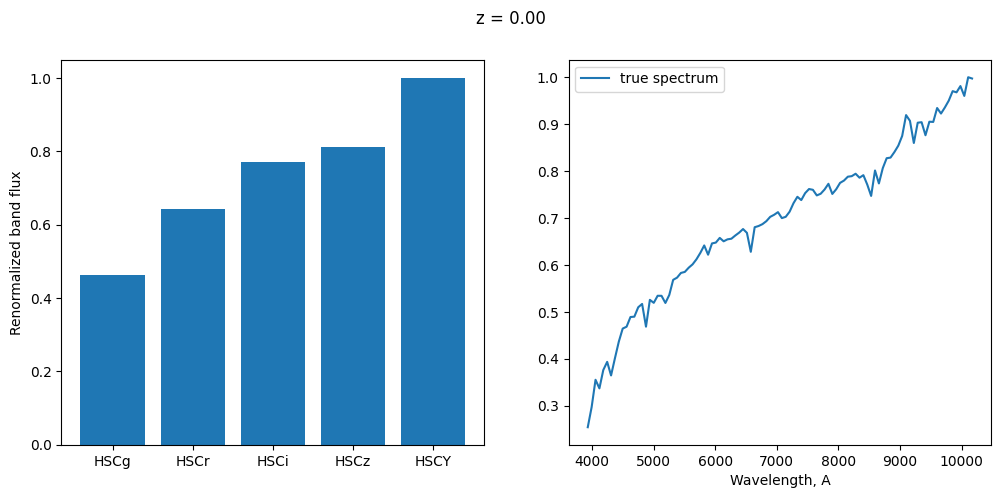

[0.   0.1  0.15]


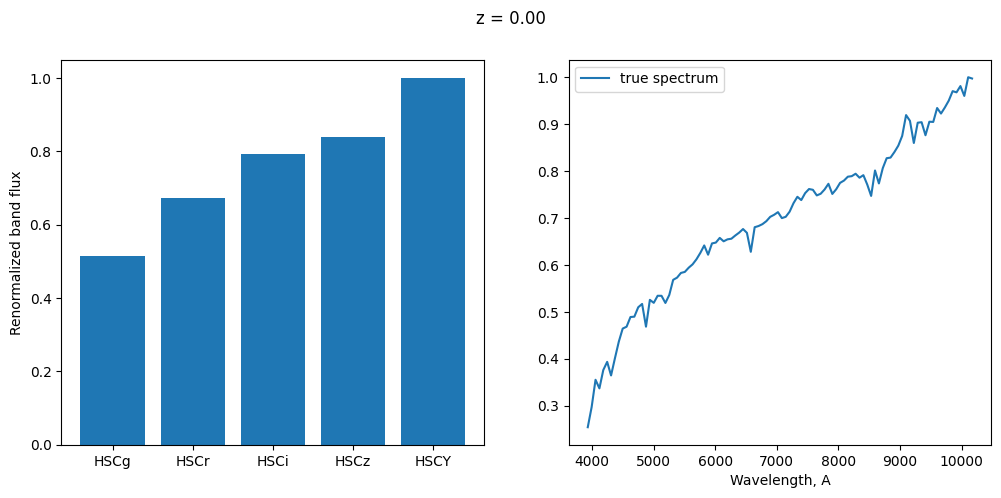

[0.   0.1  0.15]


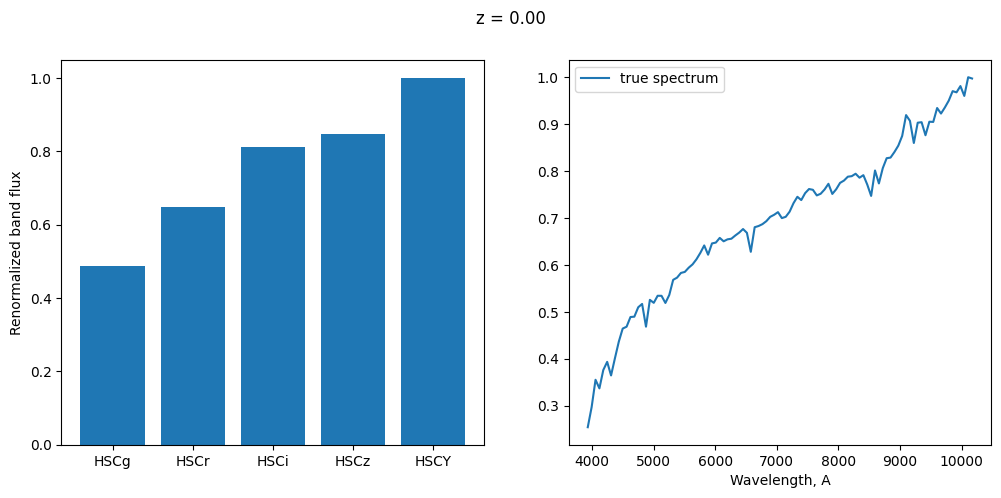

[0.   0.1  0.15]


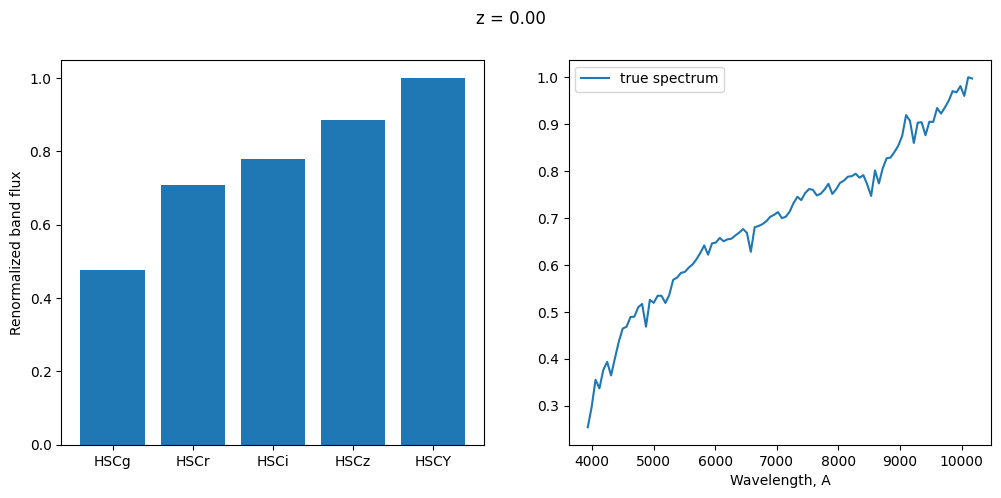

[0.   0.1  0.15]


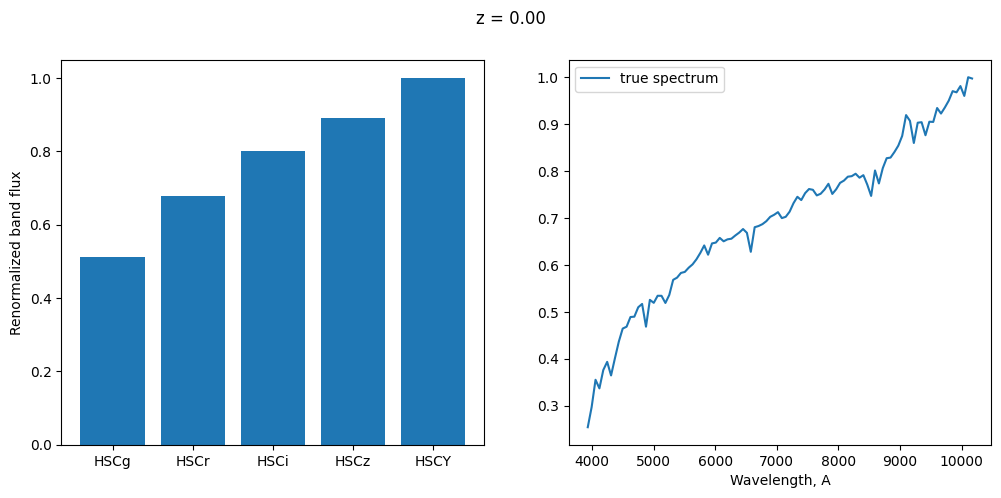

[0.   0.1  0.15]


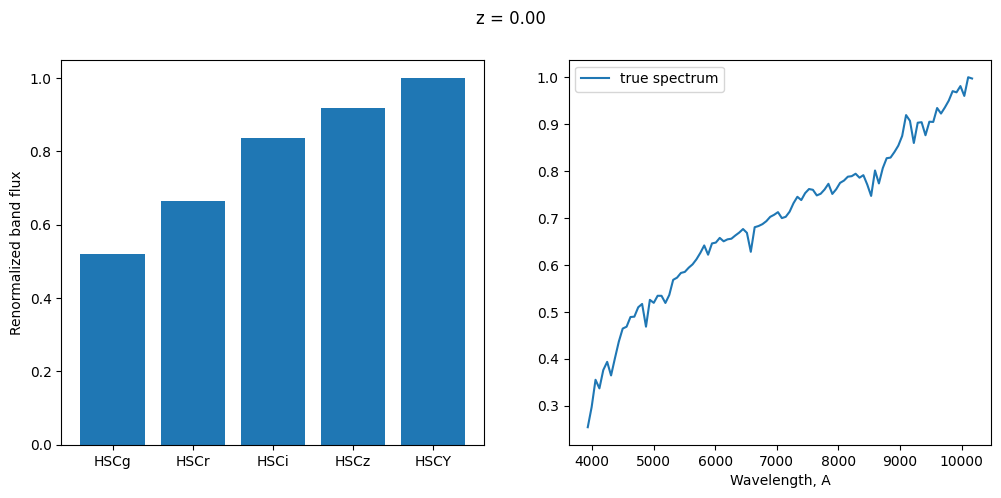

In [11]:
ii=1000
for ii in np.arange(ii, ii+10):
    fig, axs = plt.subplots(1, 2)
    fig.set_size_inches(12, 5)
    axs[1].plot(wllr, spectra[ii], label="true spectrum")
    axs[1].set_xlabel('Wavelength, A')
    axs[0].bar(filer_names, integrals[ii])
    axs[0].set_ylabel('Renormalized band flux')
    print(params[ii])
    fig.suptitle('z = %.2f' % (params[ii, 0]))
    plt.legend()
    plt.show()

In [12]:
spvae = SpectraVAE(100, 16, beta=0.00001)
spvae.compile(optimizer=keras.optimizers.Adam())
hsp=spvae.fit(spectra, epochs=50, batch_size=128, validation_split=0.2)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(128, 100))
  warnings.warn(msg)


1404/1404 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - kl_loss: 167.1850 - loss: 0.2904 - reconstruction_loss: 0.2887 - val_kl_loss: 37.0853 - val_loss: 0.4076 - val_reconstruction_loss: 0.4072
Epoch 2/50
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - kl_loss: 112.0256 - loss: 0.0225 - reconstruction_loss: 0.0214 - val_kl_loss: 46.2505 - val_loss: 0.4615 - val_reconstruction_loss: 0.4610
Epoch 3/50
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - kl_loss: 93.0075 - loss: 0.0124 - reconstruction_loss: 0.0115 - val_kl_loss: 48.0622 - val_loss: 0.5161 - val_reconstruction_loss: 0.5156
Epoch 4/50
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - kl_loss: 84.2344 - loss: 0.0112 - reconstruction_loss: 0.0103 - val_kl_loss: 48.3356 - val_loss: 0.5055 - val_reconstruction_loss: 0.5050
Epoch 5/50
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - kl_loss: 79.0380 - loss: 0.0082 - reconstruction_loss: 0.0074 - val_kl_loss: 48.2156 - val_loss: 0.5834 - val_reconstruction_loss: 0.5830
Epoch 6/50
1404/1404 ━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 100))
  warnings.warn(msg)


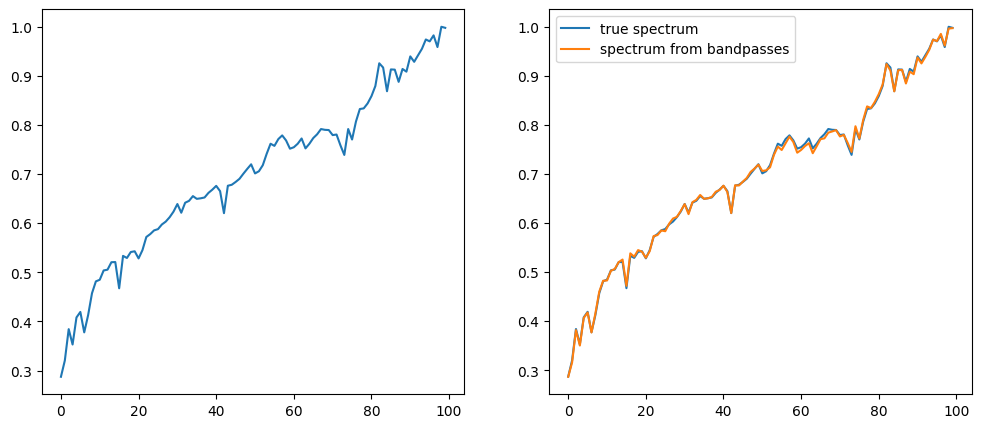

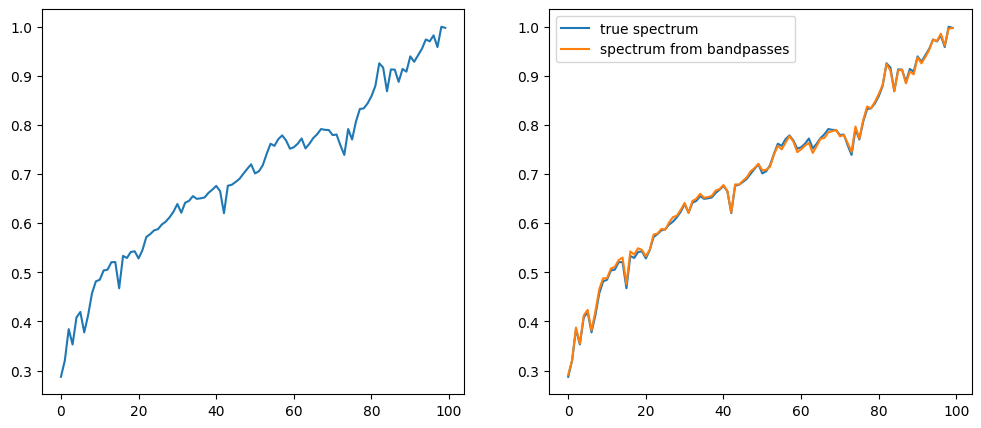

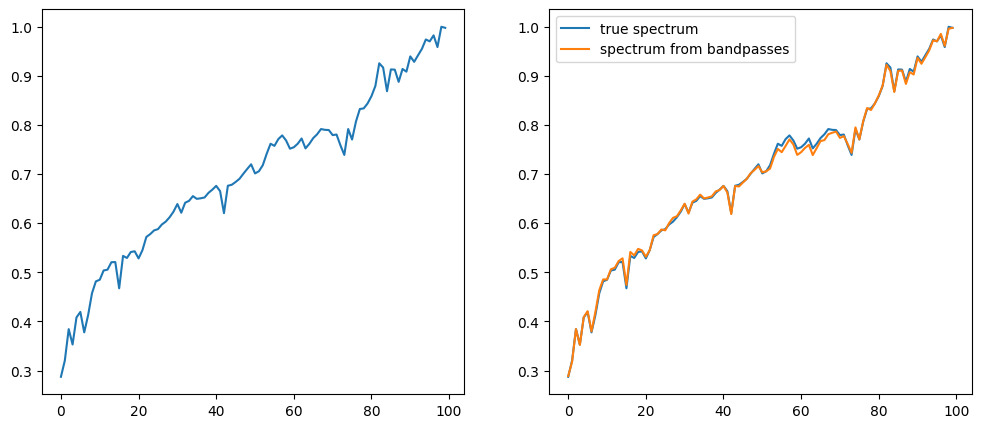

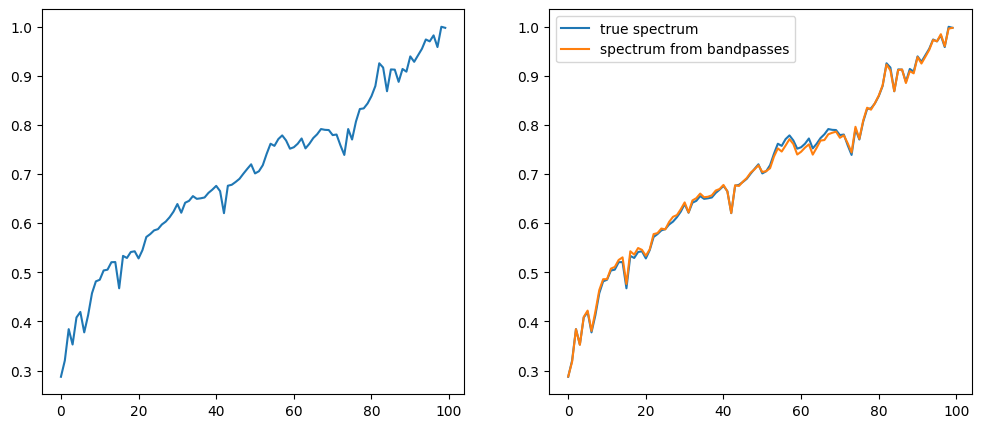

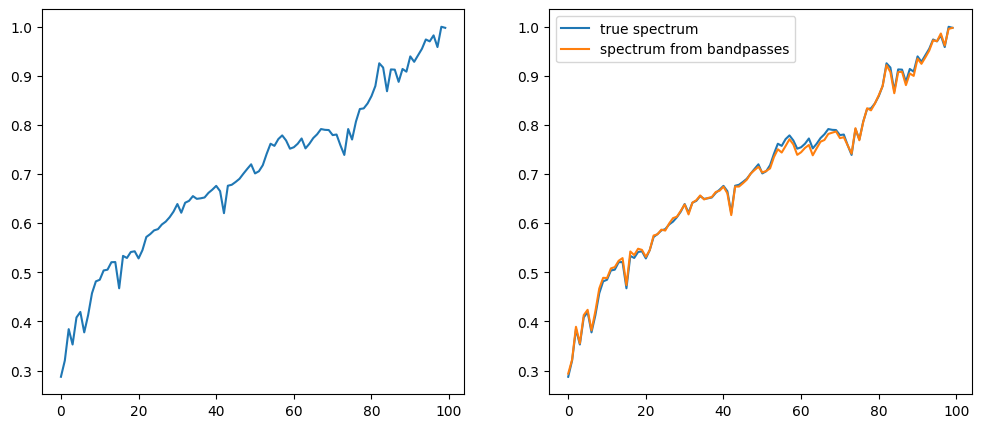

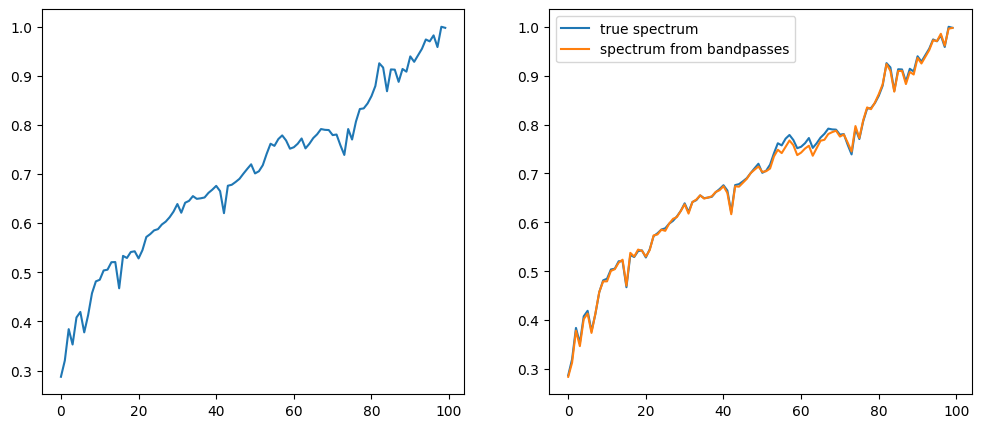

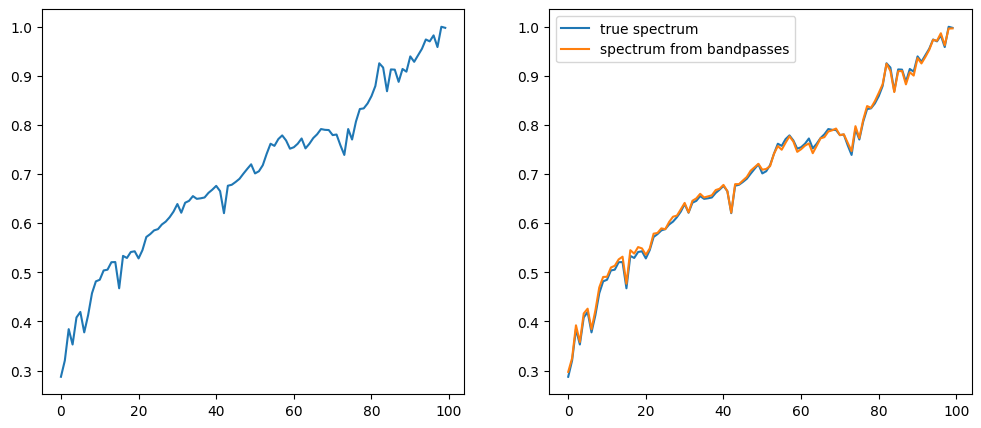

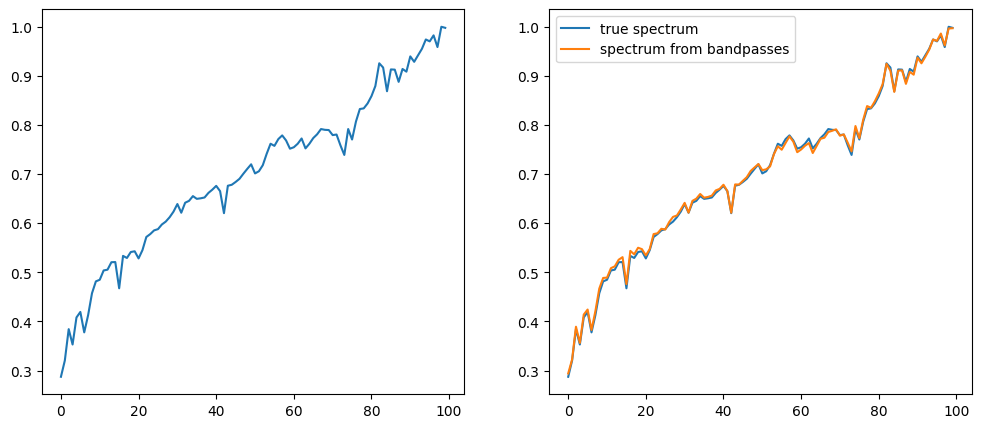

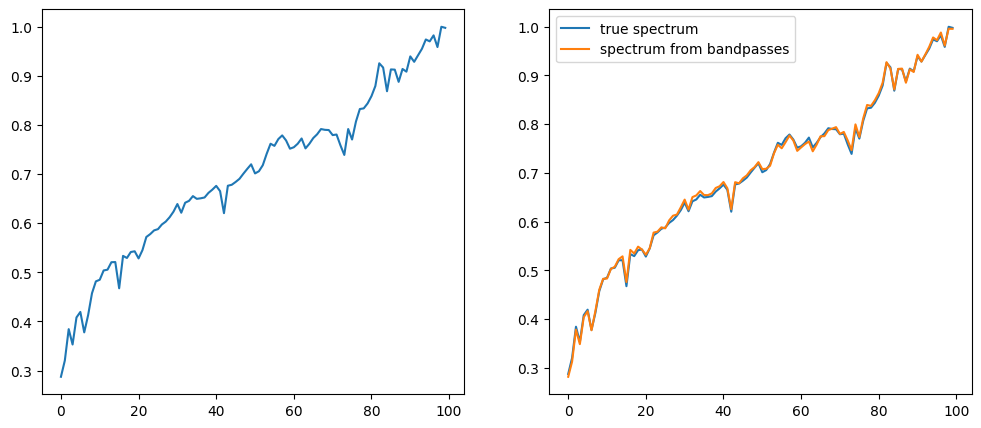

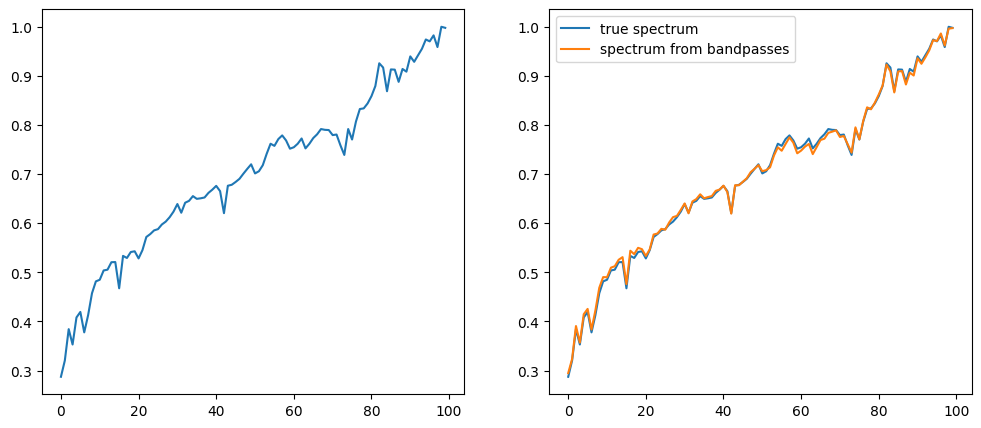

In [13]:
ii=1126
for ii in np.arange(ii, ii+10):
    fig, axs = plt.subplots(1, 2)
    fig.set_size_inches(12, 5)
    axs[1].plot(spectra[ii], label="true spectrum")
    s = spvae(np.reshape(spectra[ii], (1,100)))
    s = np.reshape(s[0].numpy(),(100,))
    axs[1].plot(s, label="spectrum from bandpasses")
    axs[0].plot(range(len(spectra[ii])), spectra[ii])
    plt.legend()
    plt.show()

In [14]:
class BandPassVAE(keras.Model):
    def __init__(self, input_dim, latent_dim, beta=1, **kwargs):
        super().__init__(**kwargs)
        self.encoder_branch = build_dense_encoder_sed_branch((input_dim,))

        self.z_mean = layers.Dense(latent_dim, name='z_mean')(self.encoder_branch.output)
        self.z_log_var = layers.Dense(latent_dim, name='z_log_var')(self.encoder_branch.output)

        self.z = Sampling()([self.z_mean, self.z_log_var])

        self.encoder = keras.Model(self.encoder_branch.inputs, [self.z_mean, self.z_log_var, self.z], name='dense_encoder')

        self.decoder = spvae.decoder
        self.decoder.trainable = False  # Prevent training of the decoder

        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.beta = beta
        #super().__init__(inputs=self.encoder.input, outputs=self.decoder.output, **kwargs)

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def apply(self, data):
        data_in = data
        z_mean, z_log_var, z = self.encoder(data_in)
        reconstruction = self.decoder(z)
        return (z_mean, z_log_var, z, reconstruction)

    def call(self, data):
        (data_in, data_out) = data[0]
        return self.apply(data_in)[3]

    def train_step(self, data):
        (data_in, data_out) = data[0]
        with tf.GradientTape() as tape:
            (z_mean, z_log_var, z, reconstruction) = self.apply(data_in)
            reconstruction_loss = ops.mean(
                tf.keras.backend.mean(tf.keras.backend.square((data_out - reconstruction)/data_out))
            )
            kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
            kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss*self.beta
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
       }

    def test_step(self, data):
        print(data)
        (data_in, data_out) = data[0]
        (z_mean, z_log_var, z, reconstruction) = self.apply(data_in)
        reconstruction_loss = ops.mean(
                #keras.losses.mean_squared_error(data, reconstruction),
                tf.keras.backend.mean(tf.keras.backend.square((data_out - reconstruction)/data_out))
        )
        kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
        kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
        total_loss = reconstruction_loss + kl_loss*self.beta
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

    def call(self, data):
        data_in  = data
        z_mean, z_log_var, z = self.encoder(data_in)
        reconstruction = self.decoder(z)
        return reconstruction

In [15]:
bpvae = BandPassVAE(5,16, beta=0.0001)
bpvae.compile(optimizer=keras.optimizers.Adam())
h=bpvae.fit((integrals, spectra), epochs=50, batch_size=128, validation_split=0.2)


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_15']
Received: inputs=Tensor(shape=(128, 5))
  warnings.warn(msg)


1402/1404 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - kl_loss: 18.2681 - loss: 0.2903 - reconstruction_loss: 0.2885((<tf.Tensor 'data:0' shape=(128, 5) dtype=float32>, <tf.Tensor 'data_1:0' shape=(128, 100) dtype=float32>),)
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - kl_loss: 18.2918 - loss: 0.2898 - reconstruction_loss: 0.2880 - val_kl_loss: 15.2969 - val_loss: 0.5894 - val_reconstruction_loss: 0.5879
Epoch 2/50
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - kl_loss: 29.0122 - loss: 0.0511 - reconstruction_loss: 0.0482 - val_kl_loss: 16.9210 - val_loss: 0.7523 - val_reconstruction_loss: 0.7506
Epoch 3/50
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - kl_loss: 29.7004 - loss: 0.0408 - reconstruction_loss: 0.0378 - val_kl_loss: 18.6103 - val_loss: 0.7253 - val_reconstruction_loss: 0.7235
Epoch 4/50
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - kl_loss: 29.2749 - loss: 0.0350 - reconstruction_loss: 0.0320 - val_kl_loss: 18.1842 - val_loss: 0.5720 - val_reconstruction_loss: 0.5702
Epoch 5/50
1404/1

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_15']
Received: inputs=Tensor(shape=(1, 5))
  warnings.warn(msg)


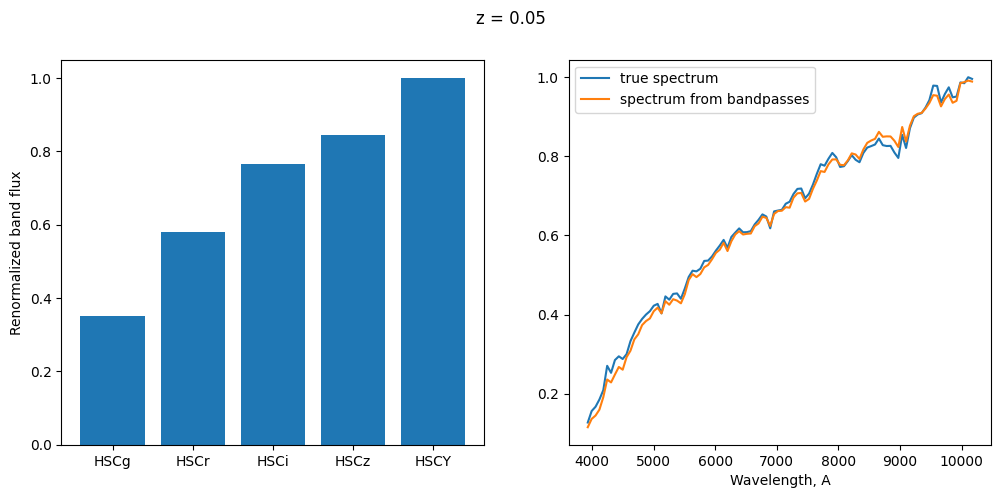

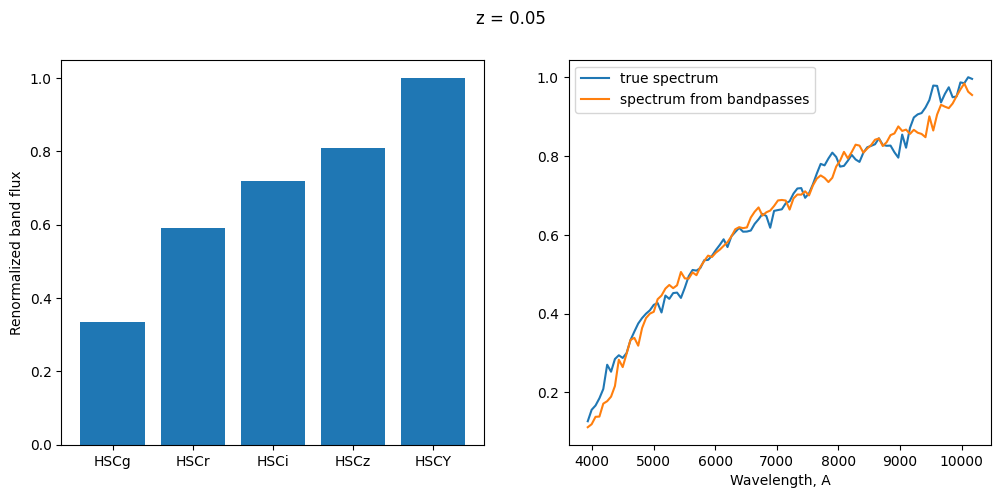

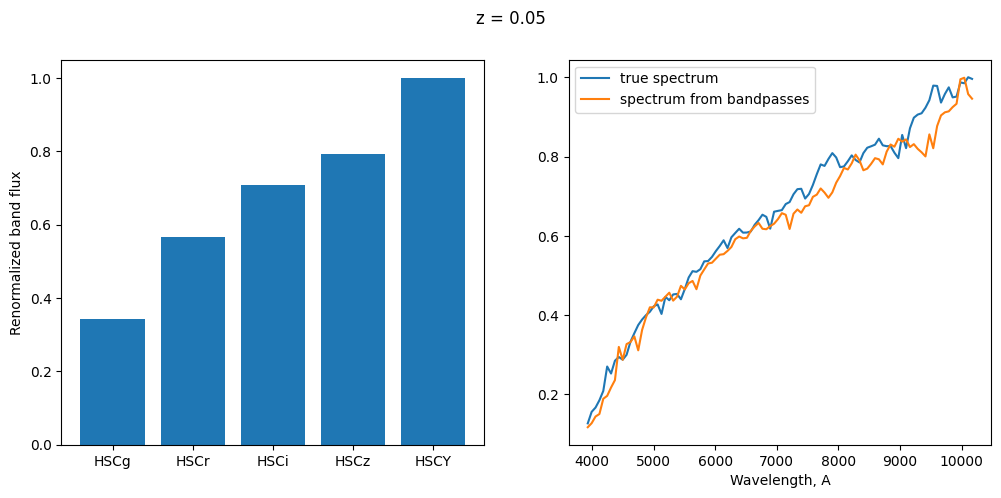

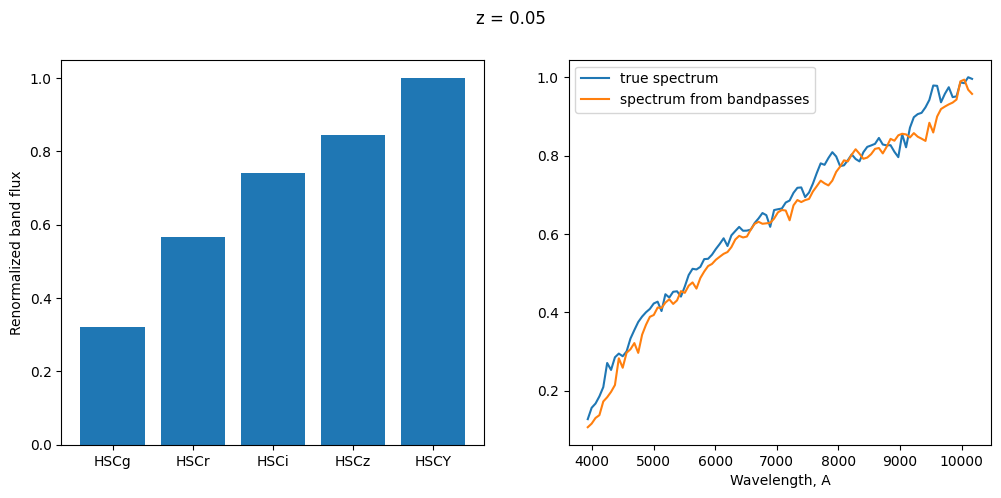

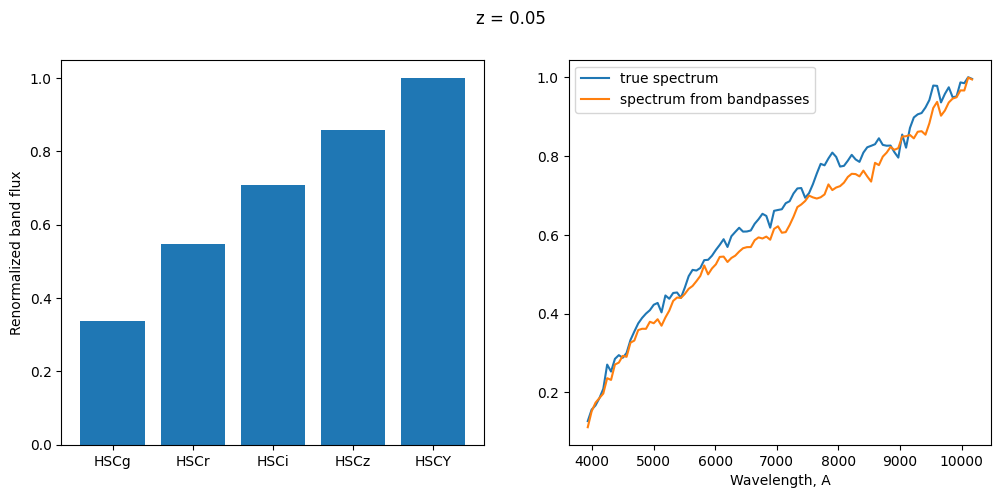

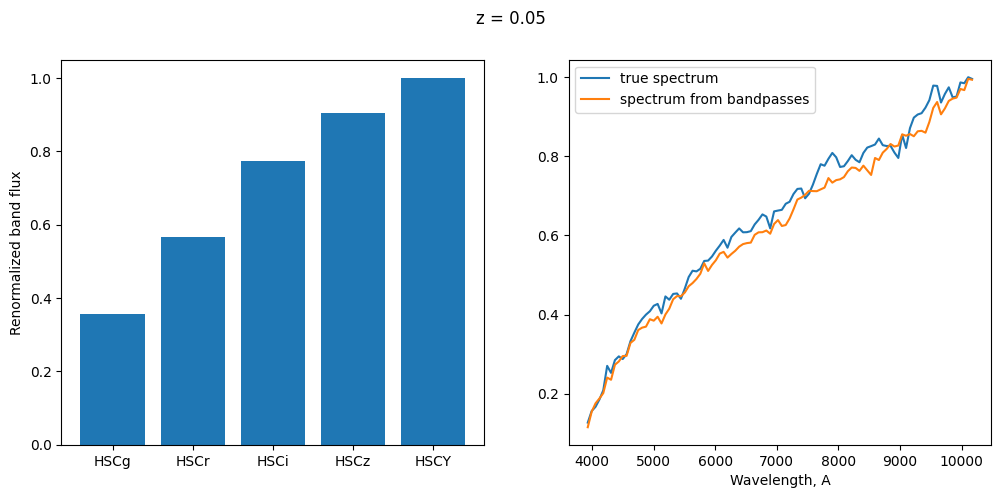

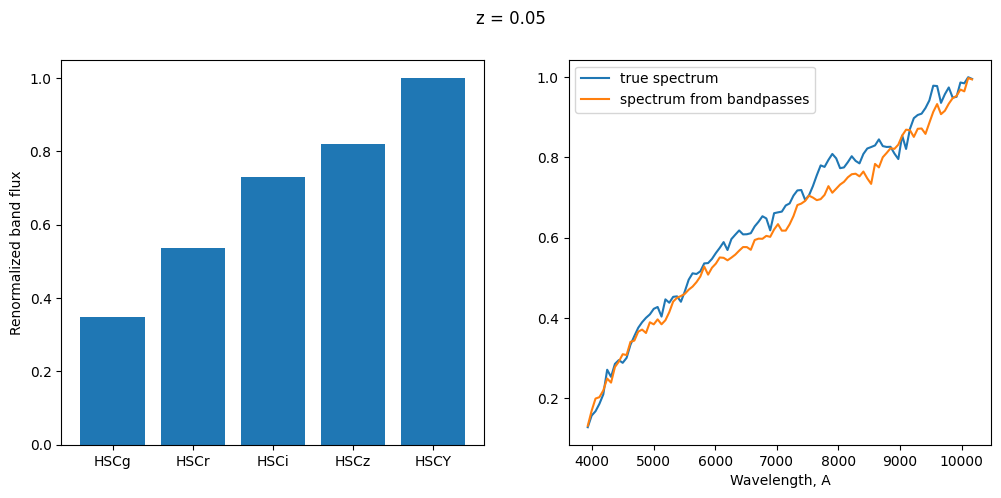

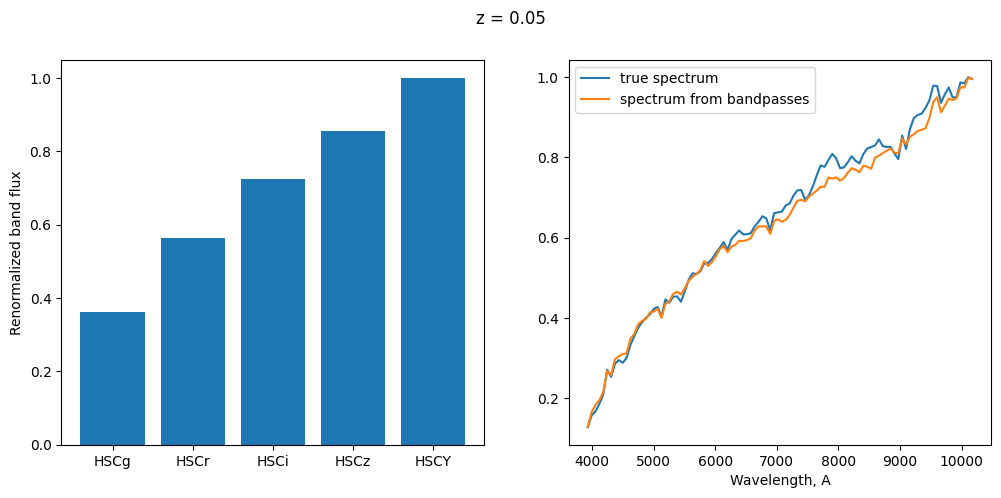

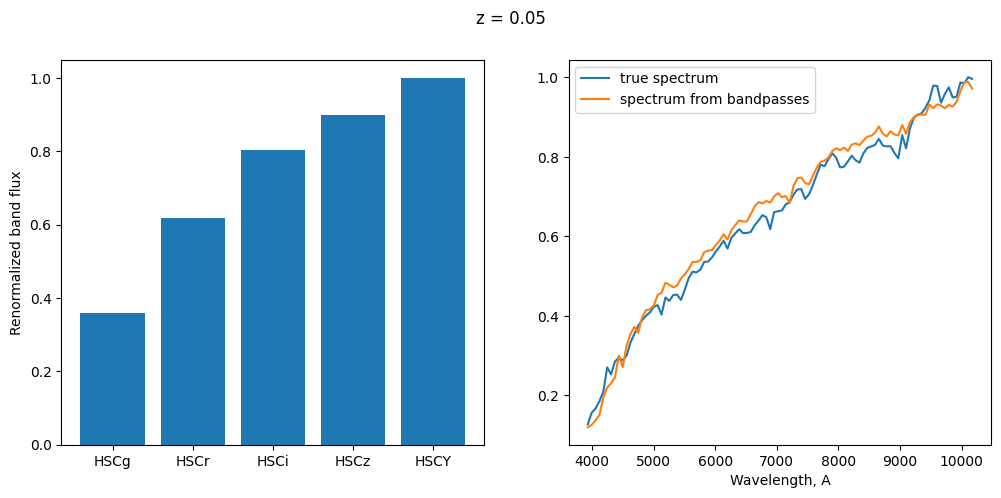

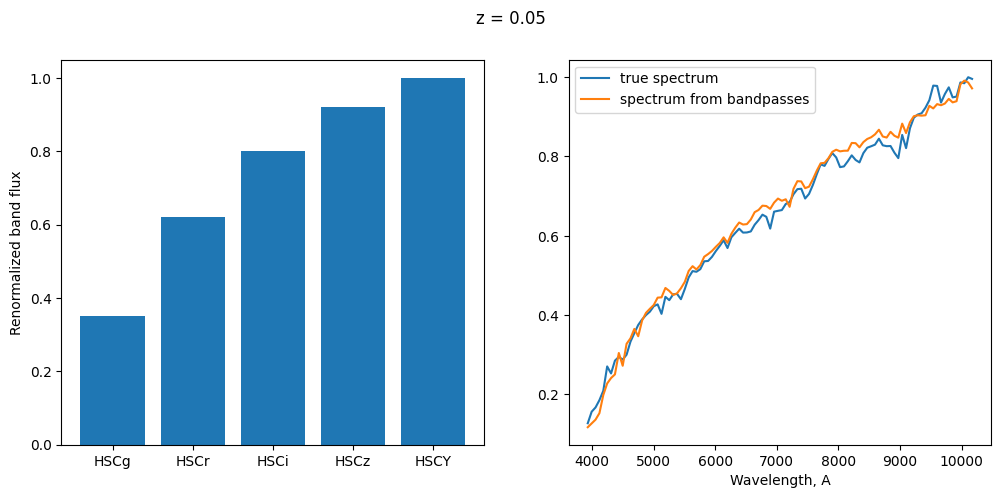

In [16]:
ii=10126
for ii in np.arange(ii, ii+10):
    fig, axs = plt.subplots(1, 2)
    fig.set_size_inches(12, 5)
    axs[1].plot(wllr, spectra[ii], label="true spectrum")
    s = bpvae(np.reshape(integrals[ii], (1,5)))
    s = np.reshape(s[0].numpy(),(100,))
    axs[1].plot(wllr, s, label="spectrum from bandpasses")
    axs[1].set_xlabel('Wavelength, A')
    axs[0].bar(filer_names, integrals[ii])
    axs[0].set_ylabel('Renormalized band flux')
    fig.suptitle('z = %.2f' % (params[ii, 0]))
    plt.legend()
    plt.show()

In [17]:
def build_dense_decoder_param(latent_dim, output_dim):
    latent_inputs = layers.Input(shape=(latent_dim,), name='z_sampling')
    x = layers.Dense(16, activation='relu')(latent_inputs)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dense(32, activation='relu')(x)
    outputs = layers.Dense(output_dim[0])(x)

    decoder = keras.Model(latent_inputs, outputs, name='dense_decoder')
    return decoder


class ParamVAE(keras.Model):
    def __init__(self, input_dim, latent_dim, beta=1, **kwargs):
        super().__init__(**kwargs)
        self.encoder_branch = build_dense_encoder_sed_branch((input_dim,))

        self.z_mean = layers.Dense(latent_dim, name='z_mean')(self.encoder_branch.output)
        self.z_log_var = layers.Dense(latent_dim, name='z_log_var')(self.encoder_branch.output)

        self.z = Sampling()([self.z_mean, self.z_log_var])

        self.encoder = bpvae.encoder
        self.encoder.trainable = False  # Prevent training of the decoder

        self.decoder = build_dense_decoder_param(latent_dim,(3,1))
        self.decoder.trainable = True  # Prevent training of the decoder

        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.beta = beta
        #super().__init__(inputs=self.encoder.input, outputs=self.decoder.output, **kwargs)

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def apply(self, data):
        data_in = data
        z_mean, z_log_var, z = self.encoder(data_in)
        reconstruction = self.decoder(z)
        return (z_mean, z_log_var, z, reconstruction)

    def call(self, data):
        (data_in, data_out) = data[0]
        return self.apply(data_in)[3]

    def train_step(self, data):
        (data_in, data_out) = data[0]
        with tf.GradientTape() as tape:
            (z_mean, z_log_var, z, reconstruction) = self.apply(data_in)
            reconstruction_loss = ops.mean(
                tf.keras.backend.square(data_out - reconstruction)
            )
            kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
            kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss*self.beta
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
       }

    def test_step(self, data):
        print(data)
        (data_in, data_out) = data[0]
        (z_mean, z_log_var, z, reconstruction) = self.apply(data_in)
        reconstruction_loss = ops.mean(
                #keras.losses.mean_squared_error(data, reconstruction),
                tf.keras.backend.mean(tf.keras.backend.square(data_out - reconstruction))
        )
        kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
        kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
        total_loss = reconstruction_loss + kl_loss*self.beta
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

    def call(self, data):
        data_in  = data
        z_mean, z_log_var, z = self.encoder(data_in)
        reconstruction = self.decoder(z)
        return reconstruction

In [18]:
print(params[0])

parvae = ParamVAE(3,16, beta=0.0001)
parvae.compile(optimizer=keras.optimizers.Adam())
h=parvae.fit((integrals, params), epochs=50, batch_size=128, validation_split=0.2)

[0.   0.04 0.15]
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:774: UserWarning: Gradients do not exist for variables ['dense_12/kernel', 'dense_12/bias', 'dense_13/kernel', 'dense_13/bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


1386/1404 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - kl_loss: 19.9189 - loss: 0.0509 - reconstruction_loss: 0.0489((<tf.Tensor 'data:0' shape=(128, 5) dtype=float32>, <tf.Tensor 'data_1:0' shape=(128, 3) dtype=float32>),)
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - kl_loss: 19.9194 - loss: 0.0507 - reconstruction_loss: 0.0487 - val_kl_loss: 28.0918 - val_loss: 0.1017 - val_reconstruction_loss: 0.0989
Epoch 2/50
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - kl_loss: 19.9189 - loss: 0.0345 - reconstruction_loss: 0.0325 - val_kl_loss: 28.0918 - val_loss: 0.0897 - val_reconstruction_loss: 0.0869
Epoch 3/50
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - kl_loss: 19.9196 - loss: 0.0328 - reconstruction_loss: 0.0308 - val_kl_loss: 28.0918 - val_loss: 0.0642 - val_reconstruction_loss: 0.0614
Epoch 4/50
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - kl_loss: 19.9194 - loss: 0.0320 - reconstruction_loss: 0.0300 - val_kl_loss: 28.0918 - val_loss: 0.0944 - val_reconstruction_loss: 0.0916
Epoch 5/50
1404/1404 

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_15']
Received: inputs=Tensor(shape=(120000, 5))
  warnings.warn(msg)


tf.Tensor([ 0.0357675   0.02929303 -0.04630436], shape=(3,), dtype=float32) [0.   0.04 0.15]


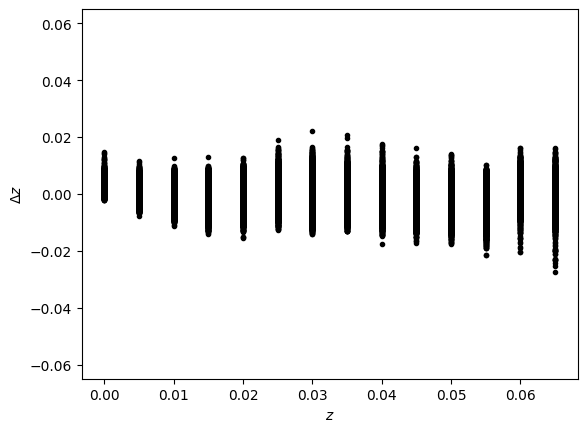

In [19]:
pnames = ['z', 't', '[Z/H]']

s = parvae(np.reshape(integrals[:120000], (120000,5)))
p = params[:120000]

res = s - p

print(s[0], p[0])
axs = (0, 0)


plx = p[:, axs[0]] / 10.0
ply = res[:, axs[1]] / 10.0
plt.plot(plx, ply, 'k.')
plt.ylim(-np.max(plx), np.max(plx))
plt.xlabel('$' + pnames[axs[0]] + '$')
plt.ylabel('$\Delta ' + pnames[axs[1]] + '$')
plt.show()


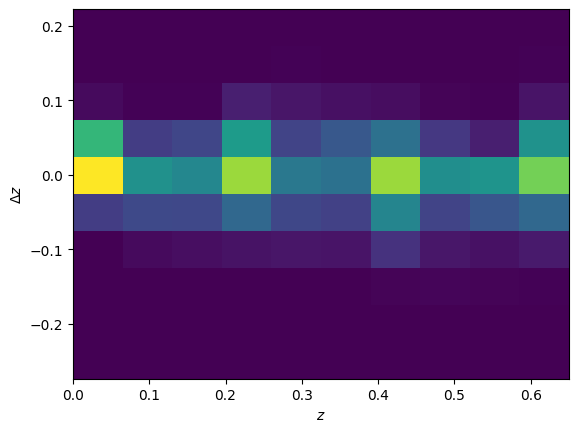

In [20]:
plx = p[:, axs[0]]
ply = res[:, axs[1]]
plt.hist2d(plx, ply, bins=10)
#plt.ylim(-np.max(plx), np.max(plx))
plt.xlabel('$' + pnames[axs[0]] + '$')
plt.ylabel('$\Delta ' + pnames[axs[1]] + '$')
plt.show()

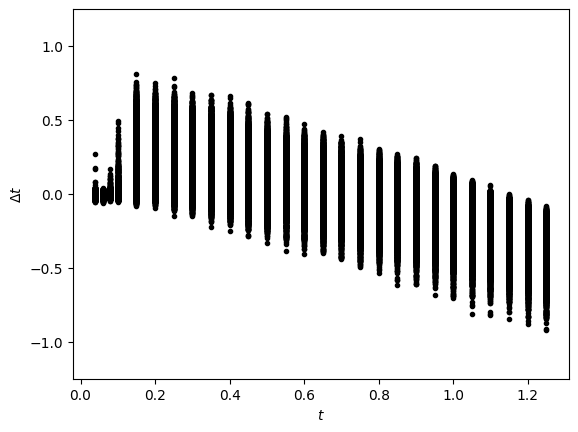

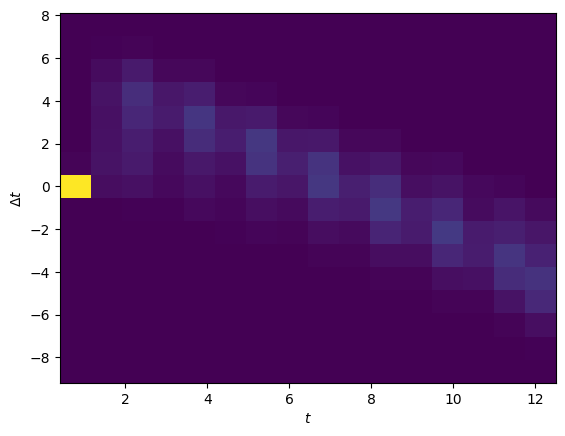

In [21]:
axs = (1, 1)


plx = p[:, axs[0]]
ply = res[:, axs[1]]
plt.plot(plx, ply, 'k.')
plt.ylim(-np.max(plx), np.max(plx))
plt.xlabel('$' + pnames[axs[0]] + '$')
plt.ylabel('$\Delta ' + pnames[axs[1]] + '$')
plt.show()

plx = p[:, axs[0]] * 10
ply = res[:, axs[1]] * 10.0
plt.hist2d(plx, ply, bins=16)
#plt.ylim(-np.max(plx), np.max(plx))
plt.xlabel('$' + pnames[axs[0]] + '$')
plt.ylabel('$\Delta ' + pnames[axs[1]] + '$')
plt.show()

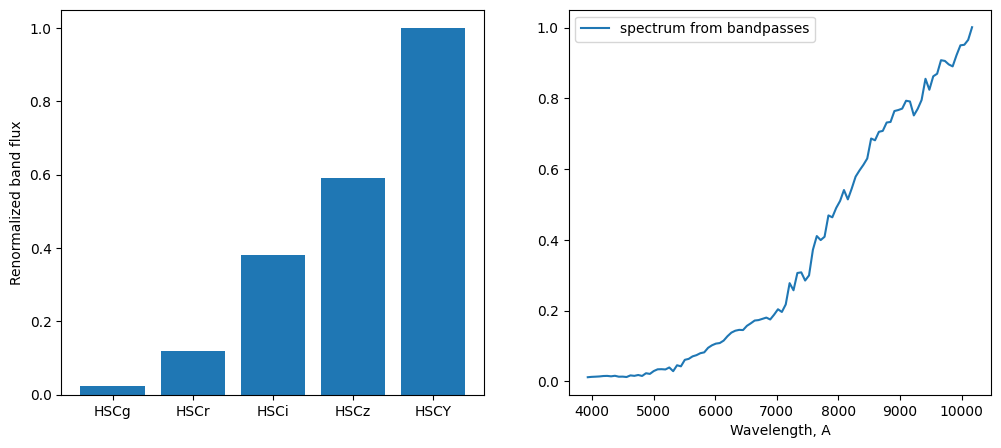

tf.Tensor([[ 0.93530947  0.40059242 -0.3157857 ]], shape=(1, 3), dtype=float32)


In [22]:
mags = np.array([24.369846, 22.666399, 21.405907, 20.927715, 20.358585])

bandfl = 10**(-0.4*mags)

bandfl /= np.max(bandfl)


fig, axs = plt.subplots(1, 2)
fig.set_size_inches(12, 5)
#axs[1].plot(wllr, spectra[ii], label="true spectrum")
s = bpvae(np.reshape(bandfl, (1,5)))
s = np.reshape(s[0].numpy(),(100,))
axs[1].plot(wllr, s, label="spectrum from bandpasses")
axs[1].set_xlabel('Wavelength, A')
axs[0].bar(filer_names, bandfl)
axs[0].set_ylabel('Renormalized band flux')
#fig.suptitle('z = %.2f' % (params[ii, 0]))
plt.legend()
plt.show()

s = parvae(np.reshape(bandfl, (1,5)))
print(s)

In [23]:
from astropy.table import Table

t_hsc = Table.read('http://gal-03.voxastro.org/~kirg/tmp/DESI_DR1_HSCSSP_clean.fits')

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_15']
Received: inputs=Tensor(shape=(118565, 5))
  warnings.warn(msg)


tf.Tensor([ 0.3842103  -0.05655526 -0.3333448 ], shape=(3,), dtype=float32) 0.9265725982810769


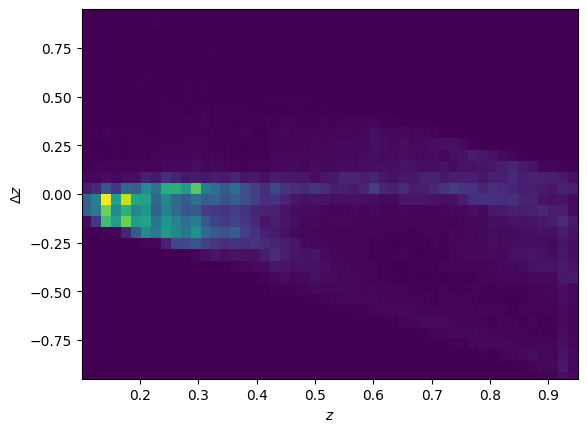

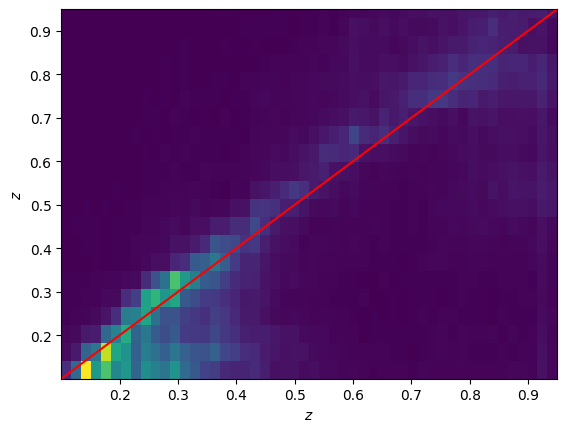

In [24]:
hsc_int = []
hsz_z = []
t_hsc = t_hsc[((t_hsc['z'] > 0.1) & (t_hsc['z'] < 0.95))]

for r in t_hsc:
    mags = mags = np.array([r['g_kronflux_mag'], r['r_kronflux_mag'], r['i_kronflux_mag'], r['z_kronflux_mag'], r['y_kronflux_mag']])
    bandfl = 10**(-0.4*mags)
    bandfl /= np.max(bandfl)
    hsc_int.append(bandfl)
    hsz_z.append(r['z'])

n = len(hsc_int)
pnames = ['z', 't', '[Z/H]']

s = parvae(np.reshape(hsc_int[:n], (n,5)))
p = hsz_z[:n]

res = s[:, 0] - p

print(s[0], p[0])
axs = (0, 0)


plx = p[:]
ply = res[:]
plt.hist2d(plx, ply, bins=50)
plt.ylim(-np.max(plx), np.max(plx))
plt.xlabel('$' + pnames[axs[0]] + '$')
plt.ylabel('$\Delta ' + pnames[axs[1]] + '$')
plt.show()


plx = p[:]
ply = res[:]
plt.hist2d(p[:], s[:, 0], bins=50)
plt.plot([0, 1], [0, 1], color='red')
plt.ylim(np.min(p[:]), np.max(p[:]))
plt.xlabel('$' + pnames[axs[0]] + '$')
plt.ylabel('$ ' + pnames[axs[1]] + '$')
plt.show()

t_hsc['z_photo'] = s[:, 0]


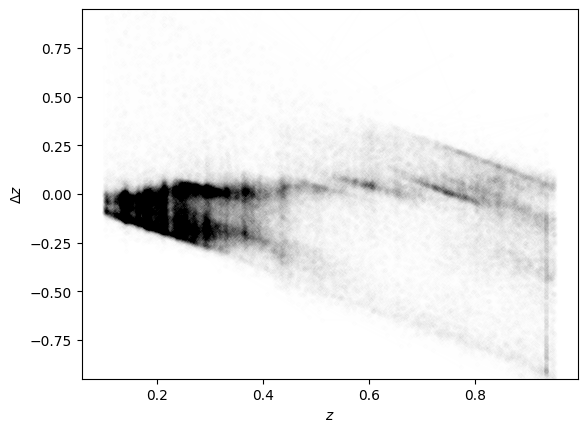

In [25]:
plx = p[:]
ply = res[:]
plt.plot(plx, ply, marker='.', color='black', linestyle=None, alpha=0.005)
plt.ylim(-np.max(plx), np.max(plx))
plt.xlabel('$' + pnames[axs[0]] + '$')
plt.ylabel('$\Delta ' + pnames[axs[1]] + '$')
plt.show()


In [26]:
t_hsc[((t_hsc['z'] < 0.5) & (t_hsc['z'] > 0.2) & (t_hsc['z_photo'] <0.1))]

object_id,ra,dec,g_kronflux_mag,r_kronflux_mag,i_kronflux_mag,z_kronflux_mag,y_kronflux_mag,z,mean_fiber_ra,targetid,tileid,zwarn,z_photo
,,,,,,,,,deg,,,,
int64,float64,float64,float32,float32,float32,float32,float32,float64,float64,int64,int32,int64,float32
38553438925115193,36.31614008173399,-3.424493847744541,19.140005,18.412647,18.058498,17.898441,17.543613,0.2382968446009609,36.31612922164305,39627700796654225,25364,0,-0.026425987
39609519843596978,32.55951114668285,-1.8135607041954795,18.97741,18.116558,17.81748,17.551537,17.454369,0.2823287268570948,32.55954586531607,39627742995548496,23833,0,0.08066755
40665317294231342,28.997962058927126,-0.8135685377746983,20.702328,19.979439,19.70906,19.546392,19.417538,0.2083504867777573,28.99796933542382,39627767091831701,22273,0,0.05065857
37476063558783314,31.536867404161868,-4.4961581895148015,21.19661,20.502176,20.20959,20.006283,20.012117,0.2927052966822492,31.53686570647807,39627676595526816,80632,0,0.09315638
39622426220320746,37.33796399933065,-2.463966863866413,19.541656,18.799736,18.475794,18.299835,18.098633,0.2526827461386599,37.33795266271289,39627724955847381,25364,0,0.031449497
37471918915346794,29.668556012074525,-5.33423294000554,23.342495,23.347042,23.27173,23.101639,22.5845,0.4227455637590999,29.66859380186696,39627658497100790,7442,4,-0.06738263
37498457518274770,38.48588096401481,-4.741592765644482,20.227013,19.433125,19.14177,18.859303,18.790497,0.3073649680246731,38.4859004053518,39627670689943916,22230,0,0.05409807
40665046711288905,29.521848647595004,-0.6395487599108697,23.02806,22.863796,22.6558,22.568726,22.383408,0.4680972275448895,29.52183845435985,39627767104406569,3263,4,0.01663071


In [27]:
t_hsc[((t_hsc['z'] < 0.99) & (t_hsc['z'] > 0.8) & (t_hsc['z_photo'] <0.4))]

object_id,ra,dec,g_kronflux_mag,r_kronflux_mag,i_kronflux_mag,z_kronflux_mag,y_kronflux_mag,z,mean_fiber_ra,targetid,tileid,zwarn,z_photo
,,,,,,,,,deg,,,,
int64,float64,float64,float32,float32,float32,float32,float32,float64,float64,int64,int32,int64,float32
37480573274442668,32.8362869577959,-5.593018440395056,23.42605,23.392971,22.989925,22.933048,22.289661,0.9265725982810769,32.83632487035203,39627652532804446,11067,0,0.3842103
37489240518446089,36.0549126324059,-5.290568618561408,22.9226,22.7435,22.515673,22.358631,22.000807,0.8655984895122414,36.05488655433243,39627658601961878,9489,4,-0.0365808
41738174354949533,30.864278710913585,1.058507661291315,23.830717,23.012173,22.621643,22.256413,22.300257,0.8306583299724624,30.86427908519369,39627809403965120,6400,0,0.09116981
41742851574357688,32.11983939256558,1.3696203617596263,20.670261,20.737873,20.61546,20.561546,20.33472,0.8943599179065235,32.11984774138375,39627815464735188,7957,2,0.035330415
39631784954042200,39.59931935292315,-1.7745766064871369,22.683632,22.588284,22.307238,22.187729,21.828566,0.8848794318148275,39.59934410144945,39627743112989858,11064,0,0.09183737
38562239313111195,39.223915324930566,-3.074773406332046,22.659092,22.514668,22.169994,22.116112,21.935478,0.8851809343679578,39.22393405671818,39627712905616616,9497,0,0.08338578
36412281763923074,29.53978799187291,-6.182456930132743,23.195438,22.774105,22.287033,21.99489,21.720219,0.8805514802754457,29.53974413809715,39627634442769267,1672,0,0.23842186
36434396550535115,36.75231432019853,-6.626845990261129,21.84398,20.507687,19.889252,19.54746,19.332058,0.8904521140611693,36.75231156296132,39627622551914231,80635,4,0.32767016


In [28]:
photoz_good = t_hsc[np.abs(t_hsc['z'] - t_hsc['z_photo']) < 0.15*(1 + t_hsc['z'])]
print(len(photoz_good), len(t_hsc), len(photoz_good)/len(t_hsc))

93392 118565 0.7876860793657487


In [29]:
t_hsc[t_hsc['z'] > 0.4]

object_id,ra,dec,g_kronflux_mag,r_kronflux_mag,i_kronflux_mag,z_kronflux_mag,y_kronflux_mag,z,mean_fiber_ra,targetid,tileid,zwarn,z_photo
,,,,,,,,,deg,,,,
int64,float64,float64,float32,float32,float32,float32,float32,float64,float64,int64,int32,int64,float32
37480573274442668,32.8362869577959,-5.593018440395056,23.42605,23.392971,22.989925,22.933048,22.289661,0.9265725982810769,32.83632487035203,39627652532804446,11067,0,0.3842103
37481281944046281,32.03682550785276,-4.70071465302428,23.18282,22.980305,22.293991,22.110775,21.826351,0.917706278198227,32.03681963290541,39627670580894403,1664,0,0.76484865
38558519871429559,36.779406310429465,-3.5387898376241256,22.825287,21.20509,20.213535,19.75261,19.521894,0.5420810151053992,36.77948731977085,39627700800855806,9489,0,0.6294589
39622447695136857,37.36221933406962,-1.5309441170693912,23.48132,23.113636,22.395777,22.220203,22.129353,0.8771188558909652,37.36222529082306,39627749115039190,3231,0,0.7440815
36421082151928961,32.5380971235688,-5.979053016109781,22.84253,22.486893,21.75785,21.523932,21.468874,0.9211800611724485,32.53808973392552,39627640499344861,6397,0,0.8155681
37480985591306303,32.37416824467576,-5.4910924242063235,21.922806,20.46147,19.752941,19.367727,19.1521,0.4532843983464141,32.3741634901146,39627652524416737,6397,0,0.5295441
39600023670908049,30.457323912975106,-2.391384298342507,21.766975,20.866713,20.002953,19.499073,19.319036,0.4815062485947352,30.45731806032535,39627724838412348,1670,0,0.57485616
37480843857379106,32.543583346602,-5.8595107080615145,23.483017,23.428127,22.721004,22.491993,22.173056,0.9010986954370324,32.54360428732895,39627646513977212,1664,0,0.7998998
